------------------------------------------------------
# Simulate data for the sdf example
------------------------------------------------------

#### Date: June 2017


In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

import statsmodels as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.base.datetools import dates_from_str
import statsmodels.formula.api as smf

/home/szokeb/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Example (but real) data from the statsmodel database
macro_data = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = macro_data[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

macro_data = macro_data[['realgdp', 'realcons', 'realinv']]
macro_data.index = pd.DatetimeIndex(quarterly)
data = np.log(macro_data).diff().dropna()


In [3]:
#=======================================
# When we use multiple series
#=======================================

#data = data.iloc[:, 1:]

#lag = 1
#model = tsa.VAR(data)
#results = model.fit(lag)

#M = len(results.names)
#L = results.k_ar
#mu = results.intercept
#A = results.coefs    

#error = np.asarray(results.resid)
#T = error.shape[0]
#Sigma = (error.T @ error)/T

In [4]:
#=======================================
# When we use a single series
#=======================================

risk_free = data.iloc[:, 1]
data = data.iloc[:, 2]

lag = 1
model = tsa.AR(data)
results = model.fit(lag)

M, Ly = 1, 1
mu, A = results.params 
mu, A = np.asarray([mu]), np.asarray([[[A]]])

error = np.asarray([results.resid]).T
sample_size = error.shape[0]
Sigma = np.asarray([[(error.T @ error)/sample_size]])

In [5]:
def stationary_dist(mu, A, Sigma):

    M, L = A.shape[2], A.shape[0] 
    K = M*L
    
    mu_comp = np.zeros((K, 1))
    mu_comp[:M, 0] = mu
    A_row = np.hstack([A[i, :, :] for i in range(L)])
    A_comp = np.vstack([A_row, 
                        np.hstack([np.eye(M*(L-1)), np.zeros((M*(L-1), M))])])
    Sigma_comp = np.zeros((M*L, M*L))
    Sigma_comp[:M, :M] = Sigma

    mu_stationary = np.linalg.solve(np.eye(K) - A_comp, mu_comp)
    Sigma_stationary = sp.linalg.solve_discrete_lyapunov(A_comp, Sigma_comp)

    return mu_stationary, Sigma_stationary


def true_model(T, mu, A, Sigma):
    '''Simulating the true model'''
    
    M, L = A.shape[2], A.shape[0] 
    K = M*L    
    mu_stationary, Sigma_stationary = stationary_dist(mu, A, Sigma)
        
    initial_x = multivariate_normal(mu_stationary.squeeze(), Sigma_stationary).rvs()
    shocks = multivariate_normal(np.zeros(len(mu)), Sigma)
    error = shocks.rvs(T).reshape(M, T)
    
    X = np.zeros((M, T + L))
    X[:, :L] = initial_x.reshape(L, M).T
    for t in range(T):
        AX = np.zeros((M, 1))
        for lag in range(L):
            AX += A[lag, :, :] @ X[:, t + L - 1 - lag].reshape(M, 1)
        X[:, t + L] = (mu.reshape(M, 1) + AX + error[:, t].reshape(M, 1)).squeeze()
    
    return pd.DataFrame(data = X.T), error

----------------------------------
## (1) Generate risk factors

In [6]:
# Simulate a dataset for Y...
simul, error_y = true_model(sample_size, np.zeros((1,1)), A, Sigma)
# ...and demean it
#simul = simul.sub(simul.mean(), axis='columns')

# The first columns of the data.dat file should be Y and its lagged version 
Y_path = np.asarray(simul)

----------------------------------
## (2) Generate a latent path

In [7]:
Lx = 1
rho = .7
sigma = .01

x_path = []

x0 = (sigma/np.sqrt(1.0 - rho*rho))*norm.rvs()
x_path.append(x0)

error_x = sigma*norm.rvs(size=sample_size)

for t in range(sample_size):
    x_path.append(rho*x_path[t] + error_x[t])
X_path = np.asarray(x_path).reshape(sample_size + Lx, 1)

In [8]:
YX_path = np.hstack([np.ones((sample_size + max(Ly, Lx), 1)), Y_path, X_path])
shocks = np.vstack([np.linalg.inv(np.linalg.cholesky(Sigma)) @ error_y, error_x.reshape(1, sample_size)/sigma])

print("dimensions of YX_path:  ", YX_path.shape)
print("dimensions of shocks :  ", shocks.shape)
print("shocks means:  ", shocks.mean(1))
print("shocks stdev:  ", shocks.std(1))

dimensions of YX_path:   (202, 3)
dimensions of shocks :   (2, 201)
shocks means:   [-0.01476776 -0.09047776]
shocks stdev:   [ 1.05167157  0.95810077]


------------------------------------------
## (3) Generate artificial returns

Suppose that returns have the following form (see RMT4 section 14.11.1 on page 590) 

$$\log R_{j, t+1} \sim \mathcal{N}\left(\nu_t(j) - \frac{1}{2}\alpha_t(j)'\alpha_t(j), \ \ \alpha_t(j)'\alpha_t(j) \right)$$

where $\nu_t(j)$ is a function of $(Y_t, X_t)$ that makes $E_t(S_{t+1}R_{j, t+1})=1$ become satisfied and 

$$\alpha_t(j) = \alpha_0(j) + \alpha_y(j)Y_t + \alpha_x(j)X_t$$

where $\alpha_0(j)$ is an $K+1$-vector and both $\alpha_y(j)$ and $\alpha_x(j)$ have $K+1$ (number of shocks) rows.

Suppose that among the elements of $Y$ we have a proxy for risk-free rate $r_{t}$ which is $t$-measurable. 

We want return paths that are generated by the (true) shocks of $(Y_t, X_t)$.

$$\nu_t(j) = r_t + \alpha_t(j)'\lambda_t$$


In [9]:
Lambda = np.asarray([[ 0.05 ,  0.6, 0.0],
                     [ 0.03 , -0.1, 0.4]])

# Suppose that alpha does not depend on the states (alpha = alpha_0)
# rows: number of assets, cols: number of shocks
alpha = np.asarray([[  .1 , .1  ],
                    [  .05, .01 ],
                    [ -.01, .1  ],
                    [  .1 , .12 ],
                    [  .07,-.1  ],
                    [ -.03,-.12 ],
                    [  .09, .12 ],
                    [ -.2 , .1  ]])
numb_returns = alpha.shape[0]

# Define data matrix that will be written into a .dat file 
simul_data = np.zeros((sample_size + max(Ly, Lx), M + 1 + numb_returns))
simul_data[:, :M] = Y_path
simul_data[:-1, M] = risk_free[:-1]

lambda_t = Lambda @ YX_path.T[:, (max(Ly, Lx)-1):-1]
risk_premia = alpha @ lambda_t
nu_path = np.ones((numb_returns, 1)) @ simul_data[(max(Ly, Lx)-1):-1, M].reshape(1, sample_size) + risk_premia

# Returns from the shocks 
logR_mean = nu_path - np.diag(alpha @ alpha.T).reshape(numb_returns, 1)/2 @ np.ones((1, sample_size))
logR = logR_mean + alpha @ shocks

simul_data[max(Ly, Lx):, M+1:] = logR.T

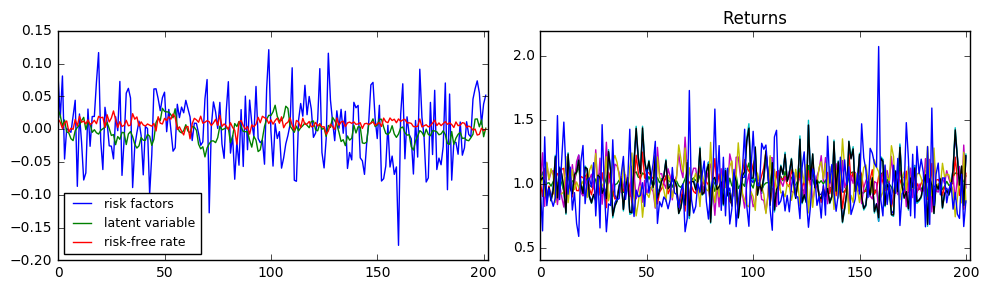

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True)
ax[0].plot(simul_data[:, :M], label='risk factors')
ax[0].plot(X_path[:, 0], label='latent variable')
ax[0].plot(simul_data[:, M], label='risk-free rate')
ax[0].set_xlim([0, sample_size+max(Ly, Lx)])
ax[0].legend(loc='best', fontsize=9)

ax[1].plot(np.exp(logR).T)
ax[1].set_title('Returns')
plt.tight_layout()

In [11]:
def formatt(x):
    if x>=0:
        return ' ' + '{: 2.10f}'.format(x)
    else:
        return '{: 2.10f}'.format(x)

In [12]:
np.savetxt('data.dat', simul_data, fmt='% 2.10f', delimiter=' ')

particle = open('initial_particle.dat', 'w')
dims = str(X_path.shape[1]) + "\n" + str(X_path.shape[0]) + "\n"
particle.write(dims)
particle.write(pd.DataFrame(X_path).to_string(header=False, index=False, float_format = formatt))
particle.close()

-----------------------------------------
## True parameter values

In [13]:
print("A: ", A[0, 0, 0], "  C_x: ", np.linalg.cholesky(Sigma)[0, 0])
print("\n")
print("rho: ", rho, "  sigma: ", sigma)
print("\n")
print("Parameters of the lambda matrix:")
print(Lambda)

A:  0.148474853179   C_x:  0.0460476812738


rho:  0.7   sigma:  0.01


Parameters of the lambda matrix:
[[ 0.05  0.6   0.  ]
 [ 0.03 -0.1   0.4 ]]


### For the proposal standard deviation set $15\%$ of the initial value

In [18]:
perc = .15
print(A[0,0,0]*perc)
print(np.linalg.cholesky(Sigma)[0, 0]*perc)
print(rho*perc)
print(sigma*perc)
print(Lambda*perc)


0.0222712279769
0.00690715219107
0.105
0.0015
[[ 0.0075  0.09    0.    ]
 [ 0.0045 -0.015   0.06  ]]
